Ссылка на репозиторий проекта:
https://github.com/andrew-tvorogov/practicum_masterskaya_2

# Маркетинг. Предсказание вероятности покупки пользователем в интернет-магазине в течение 90 дней.

<b>Описание:</b>
- Интернет-магазин собирает историю покупателей, проводит рассылки предложений и планирует будущие продажи. Для оптимизации процессов надо выделить пользователей, которые готовы совершить покупку в ближайшее время.

<b>Заказчик исследования:</b>
- yandex practicum

<b>Источник данных:</b>
- yandex practicum

<b>Содержание данных:</b>
- история покупок;
- история рекламных рассылок.

<b>Цель:</b>
- Предсказать вероятность покупки в течение 90 дней

<b>Задачи:</b>
- Изучить данные
- Разработать полезные признаки
- Создать модель для классификации пользователей
- Улучшить модель и максимизировать метрику roc_auc
- Выполнить тестирование

<b>Данные доступны в трёх файлах:</b>

- ``apparel-purchases.csv`` - история покупок
    - ``client_id`` - идентификатор пользователя
    - ``quantity`` - количество товаров в заказе
    - ``price`` - цена товара
    - ``category_ids`` - вложенные категории, к которым отнсится товар
    - ``date`` - дата покупки
    - ``message_id`` - идентификатор сообщения из рассылки

- ``apparel-messages.csv`` - история рекламных рассылок
    - ``bulk_campaign_id`` - идентификатор рекламной кампании
    - ``client_id`` - идентификатор пользователя
    - ``message_id`` - идентификатор сообщений
    - ``event`` - тип действия
    - ``channel`` - канал рассылки
    - ``date`` - дата рассылки
    - ``created_at`` - точное время создания сообщения

- ``apparel-target_binary`` - целевой бинарный признак, совершит или не совершит клиент покупку в течение следующих 90 дней
    - ``client_id`` - идентификатор пользователя
    - ``target`` - целевой признак

In [1]:
%%time

# установка пакетов

# correlation analyzer library
#!pip install phik --quiet 

!pip install catboost --quiet 

CPU times: total: 46.9 ms
Wall time: 4.96 s


In [2]:
# Загрузка библиотек
import pandas as pd
import matplotlib.pyplot as plt # для диаграмм
import math # для диаграмм
import numpy as np # для равномерного распределения значений на диаграмме
import seaborn as sns
import phik
import warnings
import ast

from catboost import Pool, CatBoostClassifier, cv

from collections import Counter

from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    MultiLabelBinarizer
)

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold

from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix

from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectKBest, f_classif

from warnings import simplefilter

In [3]:
# Функции

def dataset_info(df):
    '''
    Покажет сводную информацию по датасету
    '''
    cat_columns = df.select_dtypes('object').columns # категориальные
    num_columns = df.select_dtypes('float').columns # количественные
    datetime_columns = df.select_dtypes('datetime64[ns]').columns # датавремя
    print(f'''\n''')
    df.info()
    print(f'''\n''')
    display(df.describe())
    if (len(list(datetime_columns)) > 0):
        display(startups_data[datetime_columns].agg(['min','max']))
        print(f'''\n''')
    print(f'''\n''')
    display(df.head(3))
    print(f'''\n\nЯвных дублей: {df.duplicated().sum()}\n\n''')
    print(f'''Пропущенных значений:\n{df.isna().sum()}\n\n''')

def dataset_tm_info(df):
    '''
    Покажет информацию по datetime колонкам датасета
    '''
    datetime_columns = df.select_dtypes('datetime64[ns]').columns # датавремя
    if (len(list(datetime_columns)) > 0):
        display(df[datetime_columns].agg(['min','max']))
        #print(f'''\n''')
    else:
        print(f'''Нет колонок типа datetime\n''')

# функция для отображения круговой диаграммы распределения количества элементов по категории
def show_category_pie(df, field, title):
    '''
    Отобразит круговую диаграмму распределения количества элементов по категории
    '''
    df[field]\
    .value_counts().plot(kind='pie', title = title + ', %', autopct='%1.0f%%', figsize=(5,5))
    plt.ylabel('')
    plt.show()

# функция для отображения количественных признаков в виде графиков - гистограммы и ящика с усами
def show_numeric_bplt_hist(df, variable, first_label, second_label, bins):
    '''
    Отобразит количественные признаки в виде графиков - гистограммы и ящика с усами
    '''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.hist(df[variable], bins=bins)
    ax1.set_title('Гистограмма')
    ax1.set_xlabel(first_label)
    ax1.set_ylabel(second_label)    
    ax1.grid(True)    
    
    ax2.boxplot(df[variable], vert=False)
    ax2.set_title('Ящик с усами')
    ax2.set_xlabel(first_label)
    ax2.set_ylabel(second_label)
    ax2.grid(True)
    ax2.set_yticks([])

    plt.show()
    
def show_two_barh(df_left, df_right, field, y_label, left_title, right_title):
    '''
    Отобразит две столбчатые диаграммы(горизонтальные) распределения количества элементов по категории для двух датасетов
    '''
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))

    df_left[field].value_counts(normalize=True).sort_values().plot.barh(alpha=0.5, color=colors[0], label='', ax=ax1)
    ax1.set_title(left_title)
    ax1.set_ylabel(y_label)    
    df_right[field].value_counts(normalize=True).sort_values().plot.barh(alpha=0.5, color=colors[1], label='', ax=ax2)    
    ax2.set_title(right_title)
    plt.show()
        
def show_two_countplots(df_left, df_right, field, y_label, x_label, left_title, right_title, y_lim=(0, 100), rotation=0, sort_field=None, prefix=''):
    '''
    Отобразит две countplot диаграммы распределения количества элементов по категории для двух датасетов
    ''' 
    fig, axes = plt.subplots(1, 2)
    fig.set_size_inches(16, 4)
    
    left = sns.countplot(df_left[field], color=colors[0], ax=axes[0], alpha=0.5)
    left.set(xlabel=x_label, ylabel=y_label, title=left_title, ylim=y_lim)
    left.set_xticklabels(left.get_xticklabels(), rotation=rotation)
    
    right = sns.countplot(df_right[field], color=colors[1], ax=axes[1], alpha=0.5)
    right.set(xlabel=x_label, ylabel=y_label, title=right_title, ylim=y_lim)
    right.set_xticklabels(right.get_xticklabels(), rotation=rotation)
    
    plt.show()    

def get_category_ids_list(list_like_string):
    '''
    Создаст список из строки вида списка, например - ['1', '2', '3']
    '''
    if pd.isna(list_like_string):
        return [] # чек на null, вернёт пустой список
    return [str(i) for i in ast.literal_eval(str(list_like_string))] # разобранная строка

def show_heatmap(dataset):
    '''
    Отобразит корреляционную матрицу
    '''
    numeric_cols = dataset.select_dtypes(include=['float64','int64','Float64','Int64']).columns
    corr_matrix = dataset[numeric_cols].corr()
    plt.figure(figsize=(22,18))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
    plt.show()

def get_model_metrics(y_test, y_pred):
    '''
    Проверка модели по метрикам
    '''
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)    
            
    print(f'Accuracy = {accuracy:.3f}')
    print(f'Precision = {precision:.3f}')    
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(3,2))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
    plt.ylabel('True label')
    plt.xlabel('Predicted');

In [4]:
# инициализация глобальных переменных
RANDOM_STATE = 42 # Deep Thought number
TEST_SIZE = 0.25 # размер выборки

In [5]:
# настройки
pd.options.display.max_columns = None # необходимо чтобы head отобразил все колонки
plt.rcParams['figure.figsize'] = [15, 3] # размеры графика по умолчанию
sns.set(rc={'figure.figsize':(15, 10)}) # размеры графика seaborn по умолчанию
pd.set_option('display.float_format', '{:.2f}'.format) # отобразит в колонках округленные данные до 6-ти знаков

simplefilter(action='ignore', category=FutureWarning) # уберёт предупреждение "Set `keepdims`

# цвета для диаграмм
colors = ['gray','#3672b4','#ac0936']

# Загрузка и изучение данных

## Загрузка

In [6]:
%%time

# загрузка данных в датасеты
try:
    apparel_purchases = pd.read_csv('./datasets/apparel-purchases.csv') # история покупок
    apparel_messages = pd.read_csv('./datasets/apparel-messages.csv') # история рекламных рассылок
    #apparel_messages = pd.read_csv('./datasets/apparel-messages-short.csv') # история рекламных рассылок
    apparel_target = pd.read_csv('./datasets/apparel-target_binary.csv')  # целевой признак
except:
    print("Ошибка. Данные не загружены")

CPU times: total: 44.2 s
Wall time: 54.3 s


### Сводная информация датасет - ``apparel_purchases``

In [7]:
%%time

dataset_info(apparel_purchases)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB




,client_id,quantity,price
count,202208.00,202208.00,202208.00
mean,1515915625596210944.00,1.01,1193.30
std,145945755.93,0.18,1342.25
min,1515915625468060928.00,1.00,1.00
25%,1515915625490081280.00,1.00,352.00
50%,1515915625557177088.00,1.00,987.00
75%,1515915625624391936.00,1.00,1699.00
max,1515915626010443520.00,30.00,85499.00


,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.00,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.00,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.00,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843




Явных дублей: 73020


Пропущенных значений:
client_id       0
quantity        0
price           0
category_ids    0
date            0
message_id      0
dtype: int64


CPU times: total: 422 ms
Wall time: 559 ms


<span style="color: darkgreen">Пропущенных значений - нет. </span><br>
<span style="color: #f85c00">Есть 73020 **явных дублей**, которые **необходимо удалить**.<br>
Типы данных выглядят нормально за исключением атрибута - **date**, который необходимо привести к типу **datetime64[ns]**.
</span>

### Сводная информация датасет - ``apparel_messages``

In [8]:
%%time

dataset_info(apparel_messages)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB




,bulk_campaign_id,client_id
count,12739798.00,12739798.00
mean,11604.59,1515915625574831616.00
std,3259.21,132970411.56
min,548.00,1515915625468060928.00
25%,8746.00,1515915625489149440.00
50%,13516.00,1515915625503432192.00
75%,14158.00,1515915625591286272.00
max,14657.00,1515915626010288640.00


,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49




Явных дублей: 48610


Пропущенных значений:
bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date                0
created_at          0
dtype: int64


CPU times: total: 30.5 s
Wall time: 30.6 s


<span style="color: darkgreen">Пропущенных значений - нет. </span><br>
<span style="color: #f85c00">Есть 48610 **явных дублей**, которые **необходимо удалить**.<br>
Типы данных выглядят нормально за исключением атрибутов - **date** и **created_at**, которые необходимо привести к типу **datetime64[ns]**.
</span>

### Сводная информация датасет - ``apparel_target``

In [9]:
dataset_info(apparel_target)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB




,client_id,target
count,49849.00,49849.00
mean,1515915625598796032.00,0.02
std,148794654.89,0.14
min,1515915625468060928.00,0.00
25%,1515915625489972736.00,0.00
50%,1515915625556614912.00,0.00
75%,1515915625633408768.00,0.00
max,1515915626010443520.00,1.00


,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0




Явных дублей: 0


Пропущенных значений:
client_id    0
target       0
dtype: int64




<span style="color: darkgreen">Пропущенных значений - нет. <br>
Явных дублей - нет.<br>
Типы данных выглядят нормально.
</span>

**Вывод:**
- Во всех трёх датасетах нет пропусков;
- В датасетах ``apparel_purchases`` и ``apparel_messages`` есть явные дубли, которые необходимо удалить;
- Так же в датасетах ``apparel_purchases`` и ``apparel_messages`` есть атрибуты ``date`` и ``created_at``, которые необходимо привети к типу **datetime64[ns]**.

# Предобработка данных

## Приведение типов данных колонок к **datetime64**

### ``apparel_purchases`` - атрибут "date"

In [10]:
date_cols = ["date"]
apparel_purchases[date_cols] = apparel_purchases[date_cols].astype("datetime64[ns]")

In [11]:
apparel_purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB


### ``apparel_messages`` - атрибуты "date" и "created_at"

In [12]:
date_cols = ["date","created_at"]
apparel_messages[date_cols] = apparel_messages[date_cols].astype("datetime64[ns]")

In [13]:
apparel_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 680.4+ MB


<span style="color: darkgreen">Типы данных в столбцах датасетов - корректны.</span>

## Удаление явных дубликатов

### ``apparel_purchases``

In [14]:
apparel_purchases.drop_duplicates(inplace=True)
apparel_purchases.head(3)

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.00,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.00,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.00,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843


In [15]:
apparel_purchases.duplicated().sum()

0

Дубликаты успешно удалены.

### ``apparel_messages``

In [16]:
apparel_messages.drop_duplicates(inplace=True)
apparel_messages.head(3)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49


In [17]:
apparel_messages.duplicated().sum()

0

Дубликаты успешно удалены.

## Анализ данных колонок типа **datetime64**

### ``apparel_purchases``

In [18]:
dataset_tm_info(apparel_purchases)

,date
min,2022-05-16
max,2024-02-16


### ``apparel_messages``

In [19]:
dataset_tm_info(apparel_messages)

,date,created_at
min,2022-05-19,2022-05-19 00:14:20
max,2024-02-15,2024-02-15 23:58:40


<span style="color: darkgreen">Диапазон дат в колонках типа datetime64 - находится в нормальных пределах. Выбросов нет.</span>

# EDA и создание новых признаков

### Работа с датасетом `apparel_purchases`

#### Создание нового признака типа list с разобранным контентом `category_ids` для дальнейшей обработки

In [20]:
apparel_purchases['category_list'] = apparel_purchases['category_ids'].apply(get_category_ids_list)

In [21]:
apparel_purchases.head(1)

,client_id,quantity,price,category_ids,date,message_id,category_list
0,1515915625468169594,1,1999.00,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,"[4, 28, 57, 431]"


#### Создание нового признака, содержащего длину цепочки категорий

In [22]:
apparel_purchases['category_chain_length'] = apparel_purchases['category_list'].apply(len)

In [23]:
apparel_purchases.head(1)

,client_id,quantity,price,category_ids,date,message_id,category_list,category_chain_length
0,1515915625468169594,1,1999.00,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,"[4, 28, 57, 431]",4


#### Определение наиболее часто используемых категорий

In [24]:
categories_to_count = [category_id for _ in apparel_purchases['category_list'] for category_id in _]
most_common_categories = [category_id for category_id, _ in Counter(categories_to_count).most_common(50)]

In [25]:
#most_common_categories

#### Создание бинарных признаков из списка категорий

In [26]:
warnings.filterwarnings("ignore", category=UserWarning) # уберёт отображение MultiLabelBinarizer warnings
# как вариант здесь можно использовать get_dummies() вместо binarizer
binarizer = MultiLabelBinarizer(classes=most_common_categories)
categories_list_binarized = binarizer.fit_transform(apparel_purchases['category_list'])
categories_binarized = pd.DataFrame(
    categories_list_binarized,
    columns = [f'category__{c}' for c in binarizer.classes_], # готовые признаки из классов
    index = apparel_purchases.index
)

In [27]:
categories_binarized.head(1)

,category__4,category__28,category__5562,category__2,category__18,category__27,category__5630,category__57,category__431,category__275,category__260,category__31,category__5631,category__62,category__244,category__432,category__258,category__6060,category__420,category__5589,category__5633,category__290,category__6058,category__421,category__29,category__213,category__441,category__5536,category__657,category__124,category__5634,category__415,category__249,category__324,category__656,category__1822,category__673,category__212,category__343,category__422,category__436,category__425,category__17,category__61,category__326,category__505,category__58,category__49,category__146,category__344
0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Добавление признака с уникальным hash набора категорий

In [28]:
apparel_purchases['category_ids_hash'] = apparel_purchases['category_ids'].apply(hash)

#### Добавление в `apparel_purchases` данных по бинарным флагам категорий

In [29]:
apparel_purchases = pd.concat([apparel_purchases, categories_binarized], axis=1)

In [30]:
apparel_purchases.head(1)

,client_id,quantity,price,category_ids,date,message_id,category_list,category_chain_length,category_ids_hash,category__4,category__28,category__5562,category__2,category__18,category__27,category__5630,category__57,category__431,category__275,category__260,category__31,category__5631,category__62,category__244,category__432,category__258,category__6060,category__420,category__5589,category__5633,category__290,category__6058,category__421,category__29,category__213,category__441,category__5536,category__657,category__124,category__5634,category__415,category__249,category__324,category__656,category__1822,category__673,category__212,category__343,category__422,category__436,category__425,category__17,category__61,category__326,category__505,category__58,category__49,category__146,category__344
0,1515915625468169594,1,1999.00,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,"[4, 28, 57, 431]",4,3589827101857507135,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Длина цепочек категорий

In [31]:
category_chain_length_df = pd.DataFrame(apparel_purchases['category_chain_length'].value_counts())
category_chain_length_df = category_chain_length_df.reset_index()
category_chain_length_df.columns = ['Длина цепочки категорий', 'Количество']
category_chain_length_df

,Длина цепочки категорий,Количество
0,4,124747
1,0,2738
2,3,736
3,1,622
4,5,345


#### Расчёт сумм заказов

In [32]:
apparel_purchases['order_amount'] = apparel_purchases['quantity'] * apparel_purchases['price']

#### Опорная дата

In [33]:
max_date = apparel_purchases['date'].max() + pd.Timedelta(days=1)
max_date

Timestamp('2024-02-17 00:00:00')

#### Агрегация числовых признаков

In [34]:
agg_funcs = {    
    'order_amount': ['sum', 'median'],
    'quantity': ['sum','mean','median'],
    'price': ['mean','min','max'],
    'category_chain_length': ['mean','min','max'],
}
apparel_client = apparel_purchases.groupby('client_id').agg(agg_funcs)
apparel_client.columns = ['_'.join(col).strip() for col in apparel_client.columns.values]
apparel_client = apparel_client.reset_index()

#### Даты первой и последней покупки клиента

In [35]:
last_purchase = apparel_purchases.groupby('client_id')['date'].max()
first_purchase = apparel_purchases.groupby('client_id')['date'].min()
apparel_client = apparel_client.merge(last_purchase.rename('last_purchase_date'), on='client_id')
apparel_client = apparel_client.merge(first_purchase.rename('first_purchase_date'), on='client_id')

#### Данные по давности последней покупки, сколько дней между первой и последней покупкой, сколько всего покупок у каждого пользователя

In [36]:
apparel_client['recency_days'] = (max_date - apparel_client['last_purchase_date']).dt.days
apparel_client['customer_age_days'] = (apparel_client['last_purchase_date'] - apparel_client['first_purchase_date']).dt.days
apparel_client['purchase_count'] = apparel_purchases.groupby('client_id').size().values

#### Уникальные категории и комбинации(hash набора)

In [37]:
apparel_client['unique_category_ids'] = apparel_purchases.groupby('client_id')['category_list'].apply(
    lambda lists: len(set(x for _ in lists for x in _))
).values
apparel_client['unique_category_sets'] = apparel_purchases.groupby('client_id')['category_ids_hash'].nunique().values

#### Суммирование бинарных данных по категориям для каждого пользователя

In [38]:
# категории в отдельную переменную для переиспользования
categories_columns = [c for c in apparel_purchases.columns if c.startswith('category__')]

In [39]:
categories_grouped = apparel_purchases.groupby('client_id')[categories_columns].sum().reset_index()
apparel_client = apparel_client.merge(categories_grouped, on='client_id', how='left')

#### Активность за 30 и 90 дней

In [40]:
for w in [30,90]:
    x = apparel_purchases['date'] >= (max_date - pd.Timedelta(days=w))
    apparel_data = apparel_purchases[x].groupby('client_id').agg(
        order_amount_last=(('order_amount','sum')),
        quantity_last=(('quantity','sum')),
        orders_last=(('date','count'))
    )
    apparel_data.columns = [f'order_amount_last_{w}_days', f'quantity_last_{w}_days', f'orders_last_{w}_days']
    apparel_client = apparel_client.merge(apparel_data, on='client_id', how='left')

In [41]:
apparel_client.fillna(0, inplace=True) # заполнит пропуски после объединений

#### Распределение суммы покупок клиента

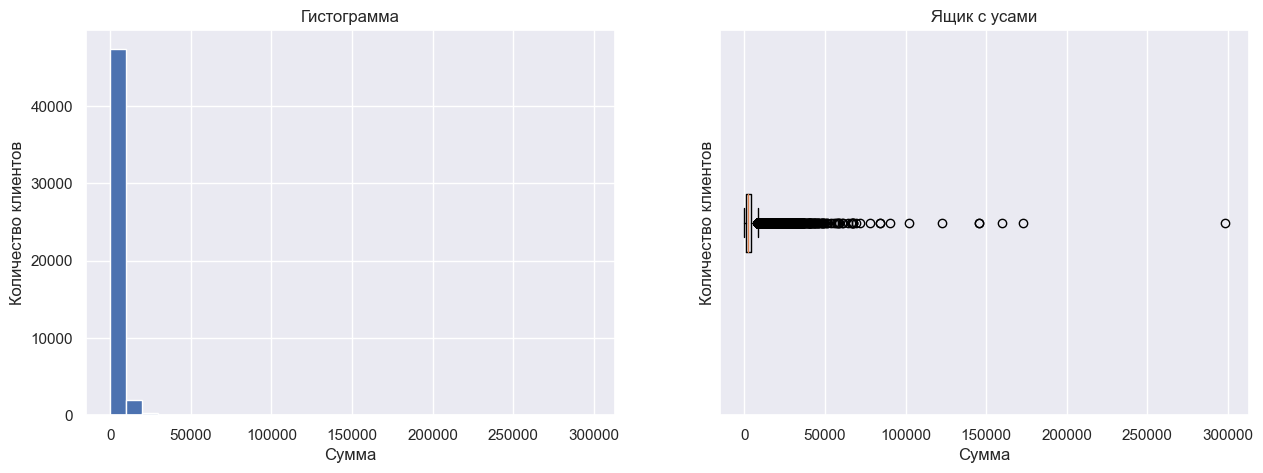

In [42]:
show_numeric_bplt_hist(apparel_client, 'order_amount_sum', 'Сумма', 'Количество клиентов', 30)

#### Распределение числа покупок клиента

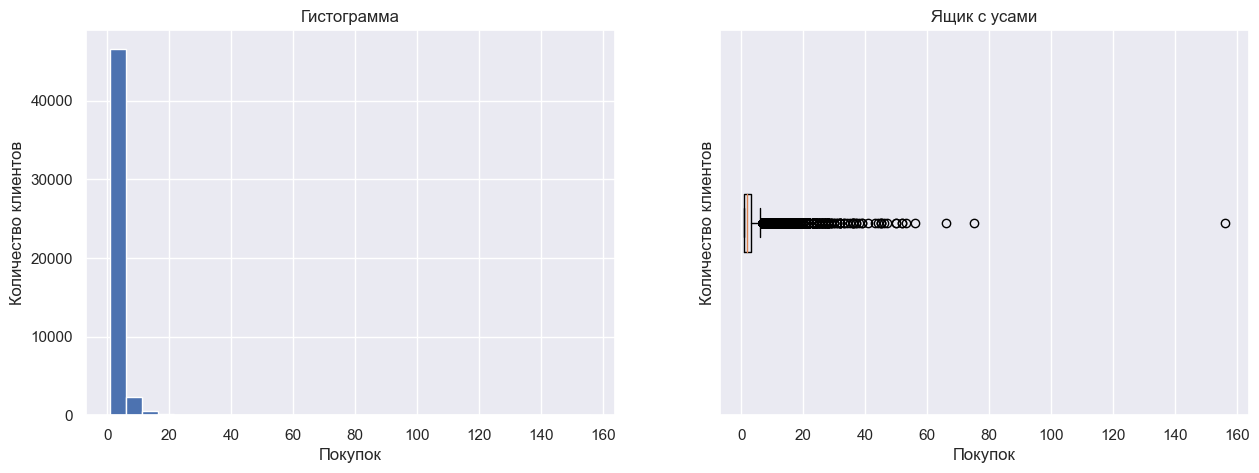

In [43]:
show_numeric_bplt_hist(apparel_client, 'purchase_count', 'Покупок', 'Количество клиентов', 30)

#### Давность последней покупки

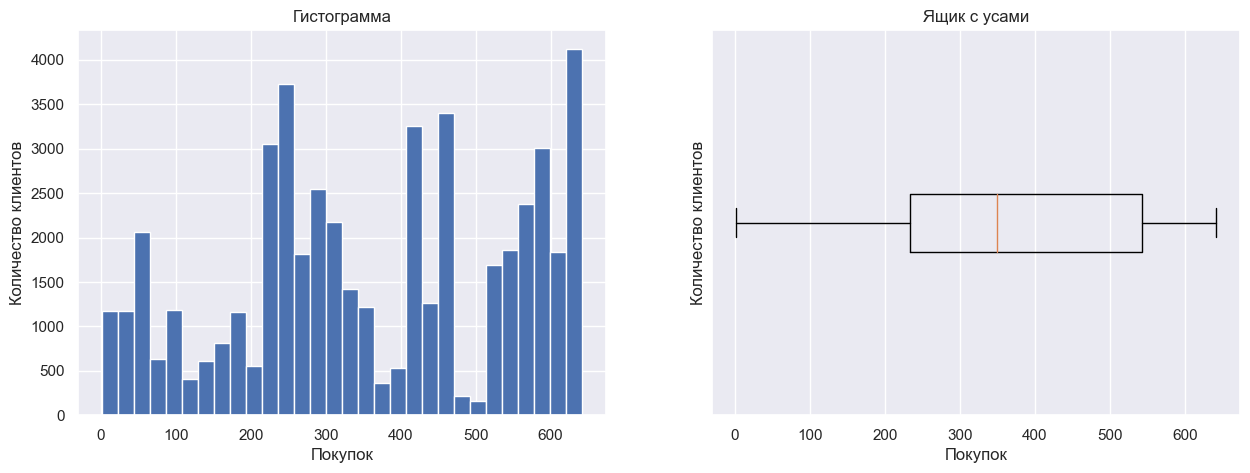

In [44]:
show_numeric_bplt_hist(apparel_client, 'recency_days', 'Покупок', 'Количество клиентов', 30)

#### Самые востребованные категории у клиентов

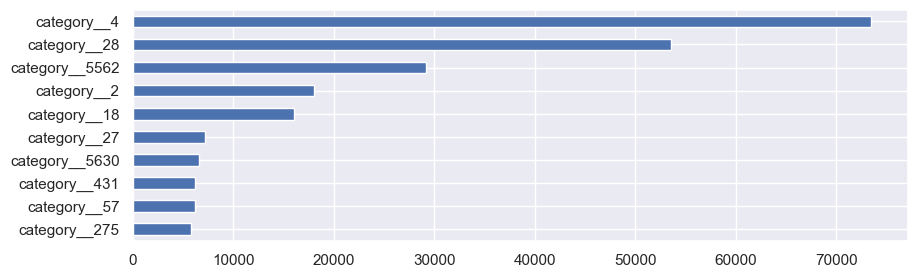

In [45]:
plt.figure(figsize=(10,3))
categories_columns_top = apparel_client[categories_columns].sum()
categories_columns_top.head(10).sort_values(ascending=True).plot(kind='barh')
plt.show()

#### Промежуточный датасет клиентов с данными из датасета `apparel_purchases`

In [46]:
apparel_client.head()

,client_id,order_amount_sum,order_amount_median,quantity_sum,quantity_mean,quantity_median,price_mean,price_min,price_max,category_chain_length_mean,category_chain_length_min,category_chain_length_max,last_purchase_date,first_purchase_date,recency_days,customer_age_days,purchase_count,unique_category_ids,unique_category_sets,category__4,category__28,category__5562,category__2,category__18,category__27,category__5630,category__57,category__431,category__275,category__260,category__31,category__5631,category__62,category__244,category__432,category__258,category__6060,category__420,category__5589,category__5633,category__290,category__6058,category__421,category__29,category__213,category__441,category__5536,category__657,category__124,category__5634,category__415,category__249,category__324,category__656,category__1822,category__673,category__212,category__343,category__422,category__436,category__425,category__17,category__61,category__326,category__505,category__58,category__49,category__146,category__344,order_amount_last_30_days,quantity_last_30_days,orders_last_30_days,order_amount_last_90_days,quantity_last_90_days,orders_last_90_days
0,1515915625468060902,4795.00,999.00,5,1.00,1.00,959.00,199.00,1999.00,4.00,4,4,2022-05-27,2022-05-27,631,0,5,13,5,5,3,0,0,0,2,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00
1,1515915625468061003,14135.00,2169.50,6,1.00,1.00,2355.83,1749.00,3499.00,4.00,4,4,2023-01-04,2023-01-04,409,0,6,4,1,6,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00
2,1515915625468061099,299.00,299.00,1,1.00,1.00,299.00,299.00,299.00,4.00,4,4,2022-05-17,2022-05-17,641,0,1,4,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00
3,1515915625468061100,1049.00,1049.00,1,1.00,1.00,1049.00,1049.00,1049.00,4.00,4,4,2024-02-10,2024-02-10,7,0,1,4,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1049.00,1.00,1.00,1049.00,1.00,1.00
4,1515915625468061170,14102.00,2194.50,8,1.00,1.00,1762.75,7.00,2699.00,3.50,0,4,2023-06-17,2023-03-26,245,83,8,10,4,6,6,0,1,1,0,0,0,0,0,5,0,0,0,1,1,1,0,5,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00


#### Shape датасета клиентов

In [47]:
apparel_client.shape

(49849, 75)

Количество записей соответствует колиечству записей в датасете `apparel_target`

### Работа с датасетом `apparel_messages`

#### Типы событий

In [48]:
 apparel_messages['event'].unique()

array(['open', 'click', 'purchase', 'send', 'unsubscribe', 'hbq_spam',
       'hard_bounce', 'subscribe', 'soft_bounce', 'complain', 'close'],
      dtype=object)

#### Каналы рассылки

In [49]:
apparel_messages['channel'].unique()

array(['email', 'mobile_push'], dtype=object)

#### Группировка по количеству, по самой ранней дате, по самой поздней, по типу события, по неуникальности

In [50]:
messages_total = apparel_messages.groupby('client_id').size().reset_index(name='messages_total_events')
messages_nunique = apparel_messages.groupby('client_id')['message_id'].nunique().reset_index(name='messages_nunique_message_ids')

# группировка по клиентам и событиям
messages_agg = apparel_messages.groupby(['client_id','event']).size().unstack(fill_value=0).reset_index()

# группировка по датам
messages_first = apparel_messages.groupby('client_id')['date'].min().reset_index(name='messages_first_date')
messages_last = apparel_messages.groupby('client_id')['date'].max().reset_index(name='messages_last_date')

#### Слияние с `apparel_client`

In [51]:
apparel_client = apparel_client.merge(messages_total, on='client_id', how='left')
apparel_client = apparel_client.merge(messages_nunique, on='client_id', how='left')
apparel_client = apparel_client.merge(messages_agg, on='client_id', how='left')
apparel_client = apparel_client.merge(messages_first, on='client_id', how='left')
apparel_client = apparel_client.merge(messages_last, on='client_id', how='left')
apparel_client['messages_recency_days'] = (max_date - apparel_client['messages_last_date']).dt.days

apparel_client = apparel_client.drop(columns=['messages_first_date','messages_last_date'])

apparel_client.fillna(0, inplace=True)

#### Shape датасета клиентов

In [52]:
apparel_client.shape

(49849, 89)

#### Info датасета клиентов

In [53]:
apparel_client.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49849 entries, 0 to 49848
Data columns (total 89 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   client_id                     49849 non-null  int64         
 1   order_amount_sum              49849 non-null  float64       
 2   order_amount_median           49849 non-null  float64       
 3   quantity_sum                  49849 non-null  int64         
 4   quantity_mean                 49849 non-null  float64       
 5   quantity_median               49849 non-null  float64       
 6   price_mean                    49849 non-null  float64       
 7   price_min                     49849 non-null  float64       
 8   price_max                     49849 non-null  float64       
 9   category_chain_length_mean    49849 non-null  float64       
 10  category_chain_length_min     49849 non-null  int64         
 11  category_chain_length_max   

# Проверка на мультиколлинеарность

In [54]:
apparel_client_ = apparel_client.drop(columns=categories_columns)

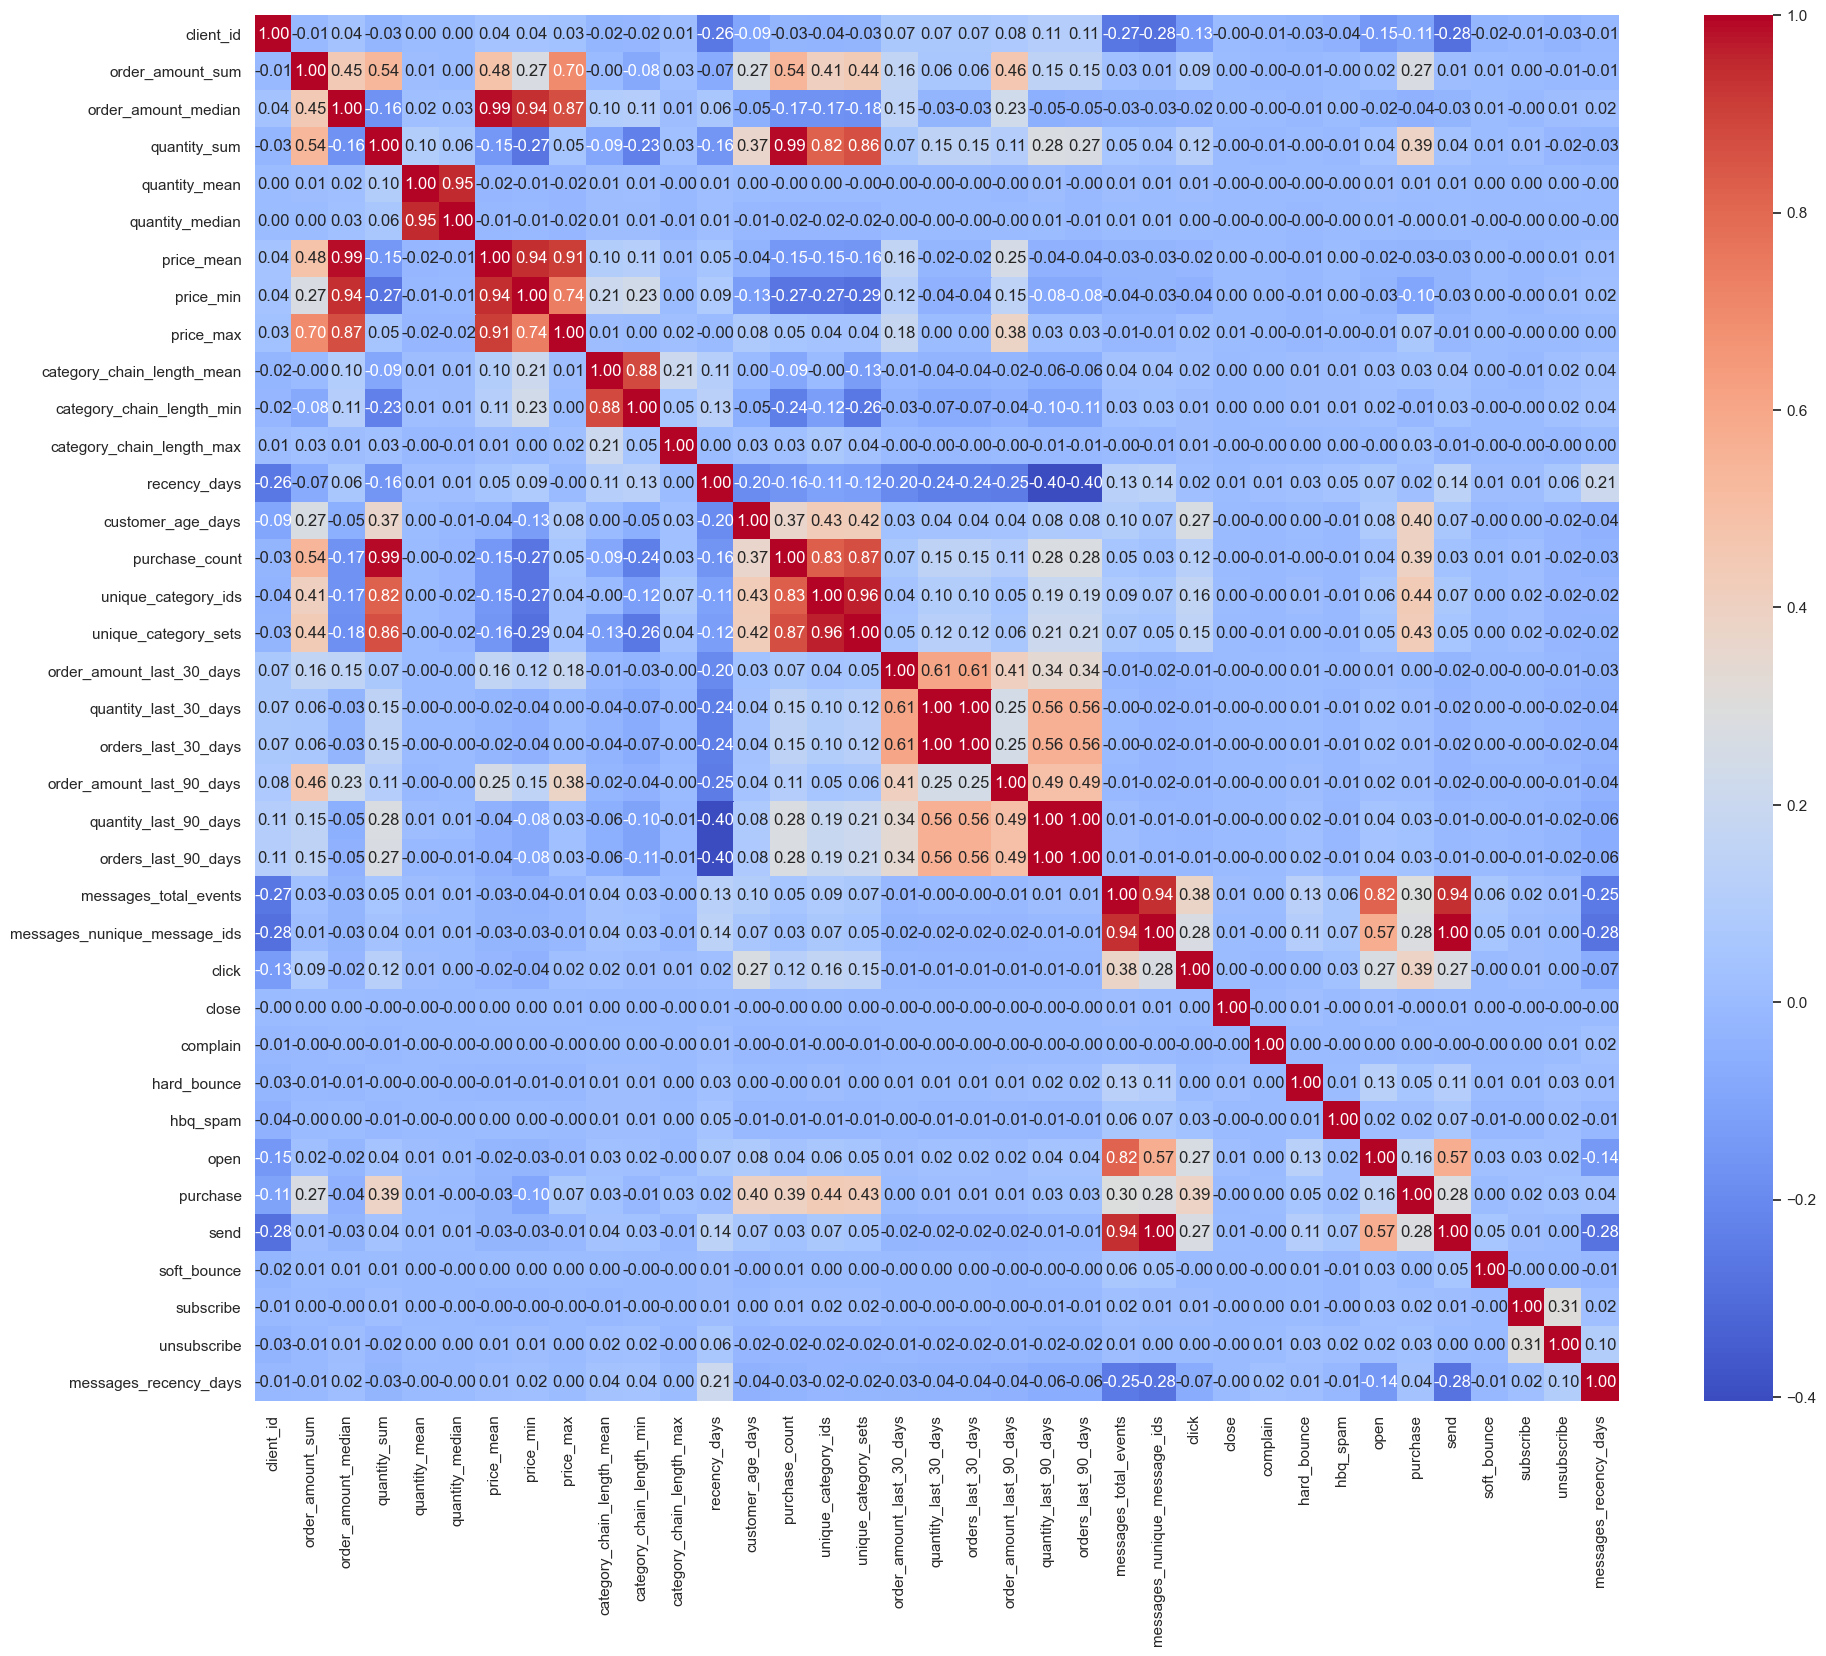

CPU times: total: 17.2 s
Wall time: 17.3 s


In [55]:
%%time

show_heatmap(apparel_client_)

На диаграмме видны несколько признаков, которые сильно коррелируют между собой. Удалим их из датасета.

In [56]:
# удаление признаков
columns_to_drop = [    
    'price_mean',
    'price_min',    
    'purchase_count',
    'quantity_median',
    'quantity_last_30_days',    
    'quantity_last_90_days',    
    'unique_category_sets',    
    'messages_nunique_message_ids',
    'messages_total_events'
]
apparel_client_prepared_ = apparel_client_.drop(columns_to_drop, axis=1)

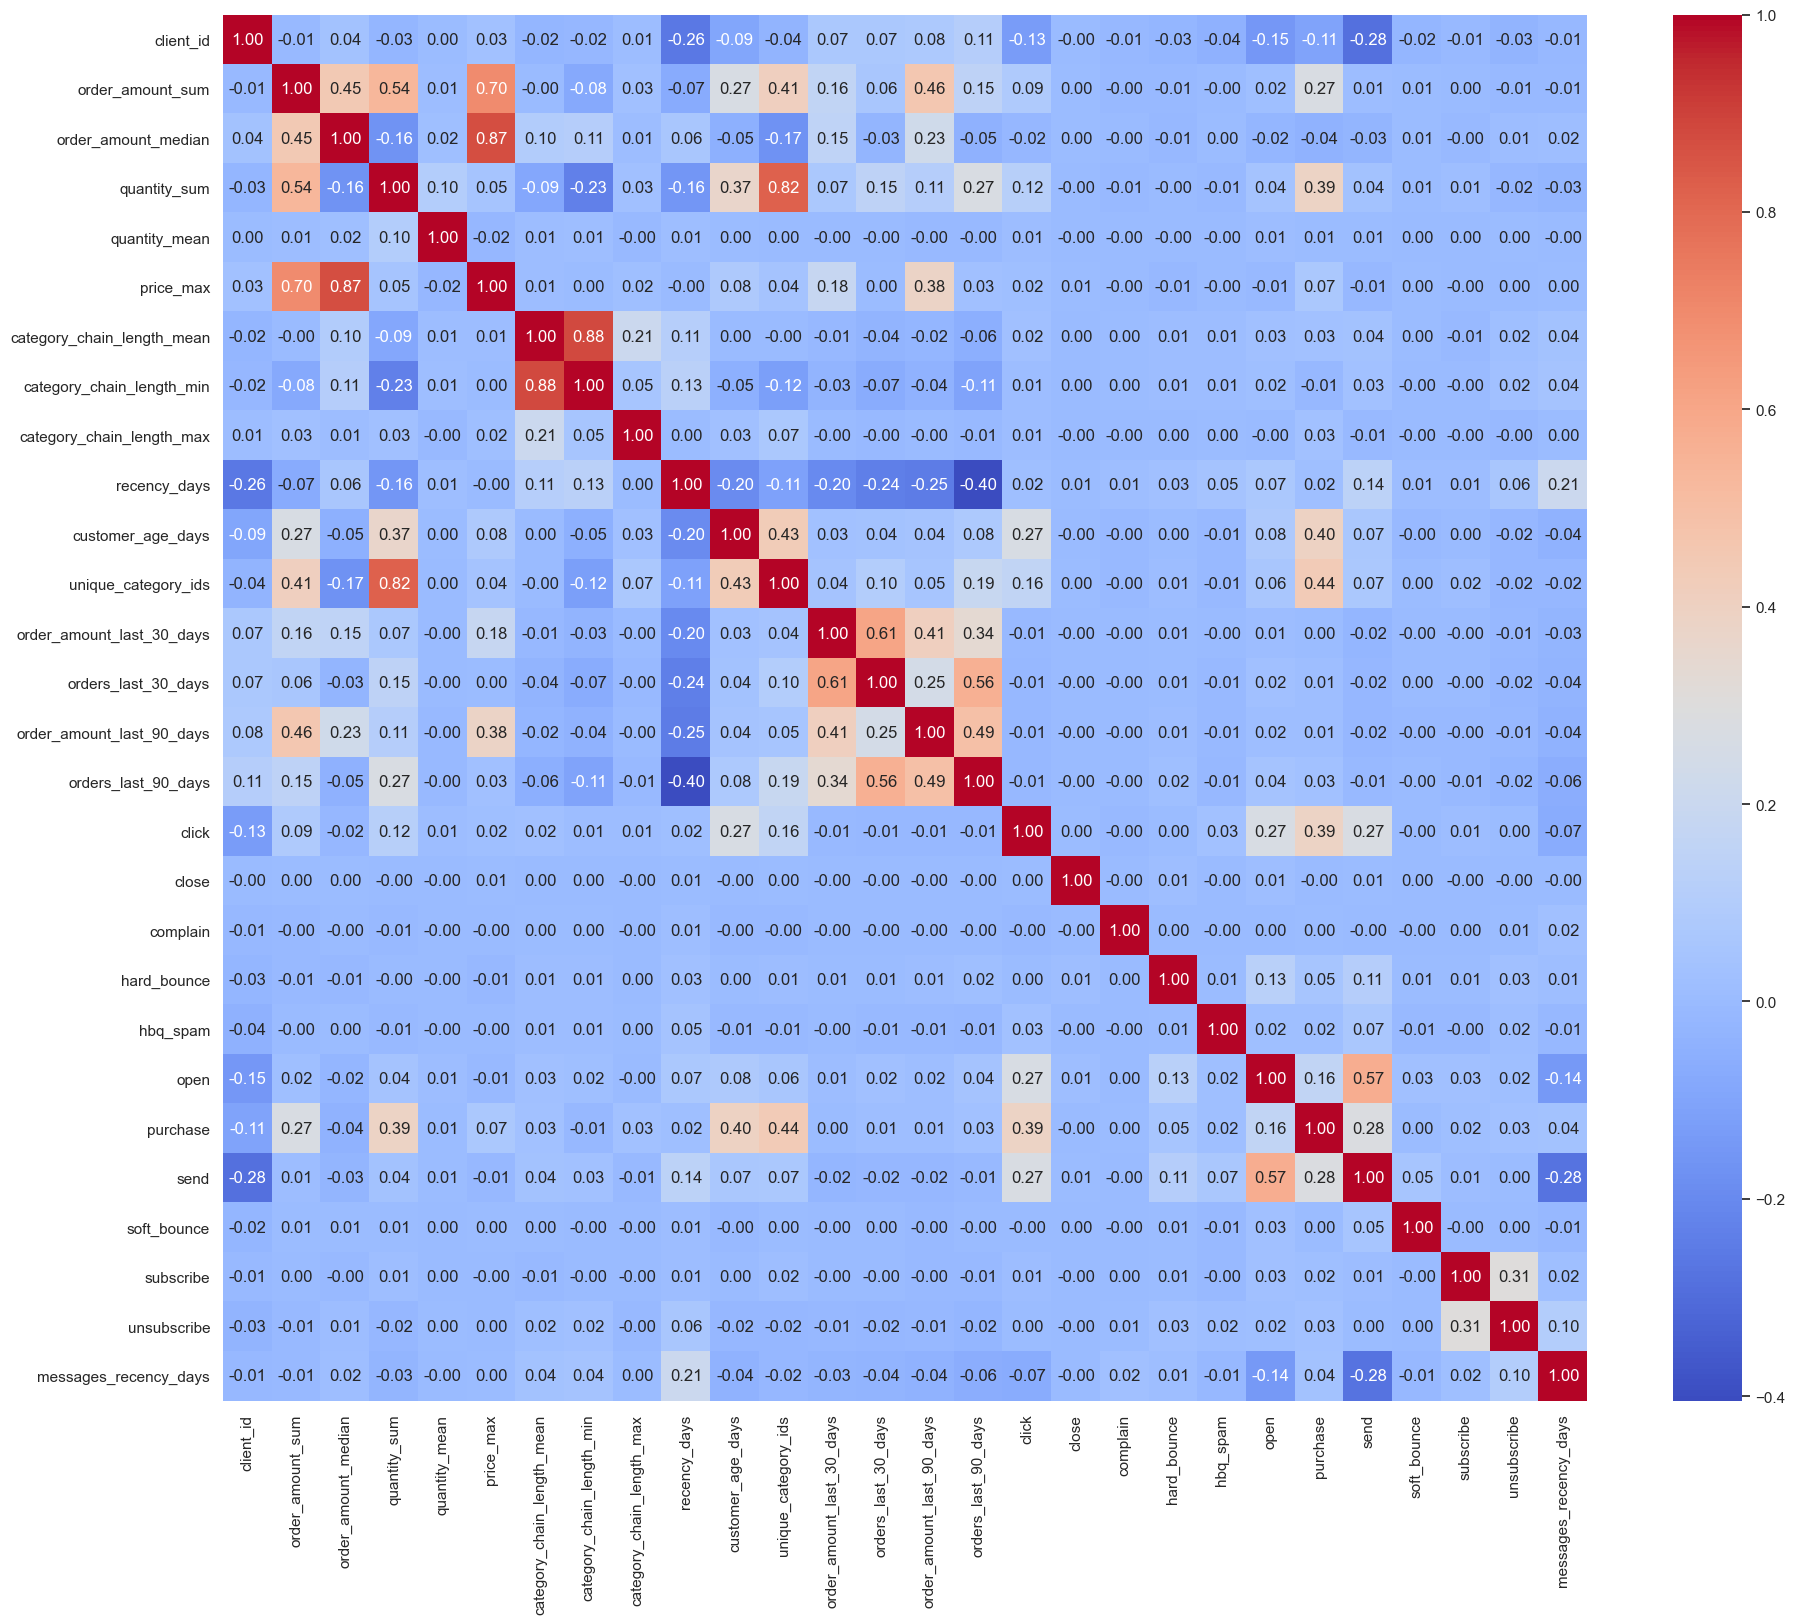

CPU times: total: 10.1 s
Wall time: 10.2 s


In [57]:
%%time

show_heatmap(apparel_client_prepared_)

In [58]:
apparel_client_prepared = apparel_client.drop(columns_to_drop, axis=1)

#### Переименование колонок в `apparel_target` для объединения с `apparel_client`

In [59]:
apparel_target = apparel_target.rename(columns={apparel_target.columns[0]:'client_id', apparel_target.columns[1]:'target'})

In [60]:
clients_data = apparel_client_prepared.merge(apparel_target, on='client_id', how='left')

#### Финальный датасет

In [61]:
clients_data.head(5)

,client_id,order_amount_sum,order_amount_median,quantity_sum,quantity_mean,price_max,category_chain_length_mean,category_chain_length_min,category_chain_length_max,last_purchase_date,first_purchase_date,recency_days,customer_age_days,unique_category_ids,category__4,category__28,category__5562,category__2,category__18,category__27,category__5630,category__57,category__431,category__275,category__260,category__31,category__5631,category__62,category__244,category__432,category__258,category__6060,category__420,category__5589,category__5633,category__290,category__6058,category__421,category__29,category__213,category__441,category__5536,category__657,category__124,category__5634,category__415,category__249,category__324,category__656,category__1822,category__673,category__212,category__343,category__422,category__436,category__425,category__17,category__61,category__326,category__505,category__58,category__49,category__146,category__344,order_amount_last_30_days,orders_last_30_days,order_amount_last_90_days,orders_last_90_days,click,close,complain,hard_bounce,hbq_spam,open,purchase,send,soft_bounce,subscribe,unsubscribe,messages_recency_days,target
0,1515915625468060902,4795.00,999.00,5,1.00,1999.00,4.00,4,4,2022-05-27,2022-05-27,631,0,13,5,3,0,0,0,2,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,10.00,0.00,0.00,0.00,0.00,35.00,5.00,126.00,0.00,0.00,1.00,29.00,0
1,1515915625468061003,14135.00,2169.50,6,1.00,3499.00,4.00,4,4,2023-01-04,2023-01-04,409,0,4,6,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,5.00,0.00,0.00,0.00,0.00,5.00,1.00,154.00,0.00,0.00,0.00,4.00,1
2,1515915625468061099,299.00,299.00,1,1.00,299.00,4.00,4,4,2022-05-17,2022-05-17,641,0,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,8.00,0.00,0.00,2.00,0.00,51.00,0.00,215.00,0.00,0.00,0.00,4.00,0
3,1515915625468061100,1049.00,1049.00,1,1.00,1049.00,4.00,4,4,2024-02-10,2024-02-10,7,0,4,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1049.00,1.00,1049.00,1.00,1.00,0.00,0.00,1.00,0.00,157.00,1.00,267.00,1.00,0.00,0.00,2.00,0
4,1515915625468061170,14102.00,2194.50,8,1.00,2699.00,3.50,0,4,2023-06-17,2023-03-26,245,83,10,6,6,0,1,1,0,0,0,0,0,5,0,0,0,1,1,1,0,5,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,16.00,0.00,0.00,0.00,0.00,31.00,3.00,243.00,0.00,0.00,0.00,2.00,0


In [62]:
clients_data.shape

(49849, 81)

#### Дополнительный финальный датасет без категорий

In [63]:
# проверка влияния признаков категорий в датасете
clients_data_no_categories = clients_data.drop(columns=categories_columns)

# Подготовка данных

### Полный датасет

In [64]:
X = clients_data.drop(['target'], axis = 1)
y = clients_data['target']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = y # выравниваем соотношение
) 

In [65]:
# вывод на экран размер получившихся данных после подготовки
print('Размеров подготовленных выборок:')
display(pd.DataFrame(
    data={
        'Входные признаки(X)': [X_train.shape, X_test.shape],
        'Целевой признак(y)': [y_train.shape, y_test.shape]
    }, 
    index=['Тренировочные данные', 'Тестовые данные']
))


Размеров подготовленных выборок:


,Входные признаки(X),Целевой признак(y)
Тренировочные данные,"(37386, 80)","(37386,)"
Тестовые данные,"(12463, 80)","(12463,)"


In [66]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37386 entries, 1094 to 18805
Data columns (total 80 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   client_id                   37386 non-null  int64         
 1   order_amount_sum            37386 non-null  float64       
 2   order_amount_median         37386 non-null  float64       
 3   quantity_sum                37386 non-null  int64         
 4   quantity_mean               37386 non-null  float64       
 5   price_max                   37386 non-null  float64       
 6   category_chain_length_mean  37386 non-null  float64       
 7   category_chain_length_min   37386 non-null  int64         
 8   category_chain_length_max   37386 non-null  int64         
 9   last_purchase_date          37386 non-null  datetime64[ns]
 10  first_purchase_date         37386 non-null  datetime64[ns]
 11  recency_days                37386 non-null  int64  

### Датасет без категорий

In [67]:
X_no_cats = clients_data_no_categories.drop(['target'], axis = 1)
y_no_cats = clients_data_no_categories['target']

X_train_no_cats, X_test_no_cats, y_train_no_cats, y_test_no_cats = train_test_split(
    X_no_cats,
    y_no_cats,
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    stratify = y_no_cats # выравниваем соотношение
) 

In [68]:
# вывод на экран размеров получившихся данных после подготовки
print('Размер подготовленных выборок:')
display(pd.DataFrame(
    data={
        'Входные признаки(X)': [X_train_no_cats.shape, X_test_no_cats.shape],
        'Целевой признак(y)': [y_train_no_cats.shape, y_test_no_cats.shape]
    }, 
    index=['Тренировочные данные', 'Тестовые данные']
))

Размер подготовленных выборок:


,Входные признаки(X),Целевой признак(y)
Тренировочные данные,"(37386, 30)","(37386,)"
Тестовые данные,"(12463, 30)","(12463,)"


In [69]:
X_train_no_cats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37386 entries, 1094 to 18805
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   client_id                   37386 non-null  int64         
 1   order_amount_sum            37386 non-null  float64       
 2   order_amount_median         37386 non-null  float64       
 3   quantity_sum                37386 non-null  int64         
 4   quantity_mean               37386 non-null  float64       
 5   price_max                   37386 non-null  float64       
 6   category_chain_length_mean  37386 non-null  float64       
 7   category_chain_length_min   37386 non-null  int64         
 8   category_chain_length_max   37386 non-null  int64         
 9   last_purchase_date          37386 non-null  datetime64[ns]
 10  first_purchase_date         37386 non-null  datetime64[ns]
 11  recency_days                37386 non-null  int64  

# Выбор и обучение моделей

Для обучения использую CatBoostClassifier. Библиотеку, которая была разработана Яндексом в 2017 году, представляет разновидность семейства алгоритмов Boosting и является усовершенствованной реализацией Gradient Boosting Decision Trees.

## CatBoostClassifier

In [70]:
#param_distributions = {
#    'iterations': [200, 400],
#    'depth': [2, 4, 6],
#    'learning_rate': [0.01, 0.05, 0.1],
#    'l2_leaf_reg': [1, 5]
#}

In [71]:
param_distributions = {
    'iterations': [250],
    'depth': [4],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 10]
}

In [72]:
catboost_classifier = CatBoostClassifier(
    eval_metric="AUC",
    random_seed=RANDOM_STATE,
    verbose=False,
    plot=True
)

search_catboost = RandomizedSearchCV(
    catboost_classifier,
    param_distributions=param_distributions,
    n_iter=5,
    scoring='roc_auc',
    cv=5,
    random_state=RANDOM_STATE,
    n_jobs=1,  
    verbose=True
)

### Полный датасет

In [73]:
%%time

search_catboost.fit(X_train, y_train, cat_features=categories_columns)

print(f'\nBest parameters: {search_catboost.best_params_}')

Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best parameters: {'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iterations': 250, 'depth': 4}
CPU times: total: 1h 39min 44s
Wall time: 15min 37s


#### Метрика roc-auc

In [74]:
best_catboost_classifier = search_catboost.best_estimator_
y_pred_proba = best_catboost_classifier.predict_proba(X_test)[:, 1]
roc_auc_best = roc_auc_score(y_test, y_pred_proba)

print(f"Метрика ROC-AUC для модели: {roc_auc_best:.4f}")

Метрика ROC-AUC для модели: 0.7431


#### Метрики accuracy и precision

Accuracy = 0.981
Precision = 1.000


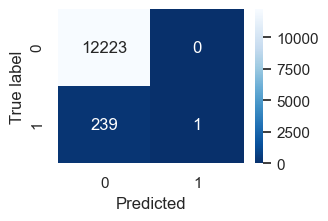

In [75]:
y_pred = best_catboost_classifier.predict(X_test)

get_model_metrics(y_test, y_pred)

### Датасет без категорий

In [76]:
param_distributions = {
    'iterations': [250],
    'depth': [4],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 10]
}

In [77]:
catboost_classifier_no_cats = CatBoostClassifier(
    eval_metric="AUC",
    random_seed=RANDOM_STATE,
    verbose=False,
    plot=True
)

search_catboost_no_cats = RandomizedSearchCV(
    catboost_classifier_no_cats,
    param_distributions=param_distributions,
    n_iter=5,
    scoring='roc_auc',
    cv=5,
    random_state=RANDOM_STATE,
    n_jobs=1,  
    verbose=True
)

In [78]:
%%time

search_catboost_no_cats.fit(X_train_no_cats, y_train_no_cats)

print(f'\nBest parameters: {search_catboost_no_cats.best_params_}')

Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best parameters: {'learning_rate': 0.1, 'l2_leaf_reg': 10, 'iterations': 250, 'depth': 4}
CPU times: total: 12min 43s
Wall time: 2min


#### Метрика roc-auc

In [79]:
best_catboost_classifier_no_cats = search_catboost_no_cats.best_estimator_
y_pred_proba_no_cats = best_catboost_classifier_no_cats.predict_proba(X_test_no_cats)[:, 1]
roc_auc_best_no_cats = roc_auc_score(y_test_no_cats, y_pred_proba_no_cats)

print(f"Метрика ROC-AUC для модели: {roc_auc_best_no_cats:.4f}")

Метрика ROC-AUC для модели: 0.7532


#### Метрики accuracy и precision

Accuracy = 0.981
Precision = 1.000


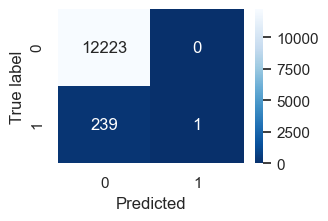

In [80]:
y_pred_no_cats = best_catboost_classifier_no_cats.predict(X_test_no_cats)

get_model_metrics(y_test_no_cats, y_pred_no_cats)

## LGBMClassifier

In [81]:
!pip install lightgbm

In [82]:
from lightgbm import LGBMClassifier

In [95]:
clients_data_no_categories_date = clients_data.drop(columns=['last_purchase_date','first_purchase_date'])

In [96]:
X_no_cats_date = clients_data_no_categories_date.drop(['target'], axis = 1)
y_no_cats_date = clients_data_no_categories_date['target']

X_train_no_cats_date, X_test_no_cats_date, y_train_no_cats_date, y_test_no_cats_date = train_test_split(
    X_no_cats_date,
    y_no_cats_date,
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    stratify = y_no_cats_date # выравниваем соотношение
) 

In [102]:
lgbm_classifier = LGBMClassifier(    
    eval_metric='auc',
    random_seed=RANDOM_STATE,
    verbose=1
)

param_distributions = {
    #'iterations': [200, 400],
    #'depth': [2, 4, 6, 8],
    #'learning_rate': [0.01, 0.05, 0.1],
    #'l2_leaf_reg': [1, 5, 10]
}

search_lgbm = RandomizedSearchCV(
    lgbm_classifier,
    param_distributions=param_distributions,
    n_iter=10,
    scoring='roc_auc',
    cv=5,
    random_state=RANDOM_STATE,
    n_jobs=1,  
    verbose=True
)

#X_train_no_cats = X_train_no_cats.drop(['last_purchase_date','first_purchase_date'], axis=1)
#X_train_no_cats.info()
search_lgbm.fit(X_train_no_cats_date, y_train_no_cats_date, eval_metric='auc')

print(f'\nBest parameters: {search_lgbm.best_params_}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 576, number of negative: 29332
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3744
[LightGBM] [Info] Number of data points in the train set: 29908, number of used features: 77
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019259 -> initscore=-3.930327
[LightGBM] [Info] Start training from score -3.930327
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 577, number of negative: 29332
[LightGBM] [Info] Auto-choosing row-wise multi-threading

## RandomForestClassifier